In [42]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from os import listdir
from os.path import isfile, join

In [43]:
def craftingMask(path):
    '''
    Pre-processing required in setting up the images and the mask
    '''
    # 1. Read an image
    originalImage = cv2.imread(path)
    
    # 2. Convert BGR to RGB for easier interpretation
    RGBimg = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

    # 3. Resizing the image to a fixed resolution
    resizedImg = cv2.resize(RGBimg, (1080, 720), interpolation = cv2.INTER_AREA)
    
    return resizedImg, resizedImg


In [44]:
def runon_folder(path) :
    '''
    Runs for each image in the directory
    '''
    files = None
    if(path[-1] != "/"):
        path = path + "/"
        files = [join(path,f) for f in listdir(path) if isfile(join(path,f))]
    fileNumber = 1
    for f in files[1:]:
        runon_image(f, fileNumber)
        fileNumber += 1
    plt.show()

In [45]:
def runon_image(path, fileNumber) :
    '''
    Scans the cheque from an image and transforms just that in a different picture
    '''
    originalImage, copyImg = craftingMask(path)
    fig = plt.figure(figsize=(15,15))
    
    copyImg_gray = cv2.cvtColor(copyImg, cv2.COLOR_BGR2GRAY)
    
    # Pre-processing for speacial kind of files
    if fileNumber == 4:
        copyImg_gray = copyImg_gray[150:500,200:900]
    
    # 0. Kernel for dilation and erosion (opening and closing)
    kernel = np.ones((7,7), np.uint8)
    erodedImage = cv2.erode(copyImg_gray, kernel, iterations=1)
    openedImage = cv2.morphologyEx(erodedImage, cv2.MORPH_OPEN, kernel)
    closedImage = cv2.morphologyEx(openedImage, cv2.MORPH_CLOSE, kernel)
    
    copyImg_blur = cv2.GaussianBlur(closedImage, (7, 7), 0)
    copyImg_edges = cv2.Canny(copyImg_blur, 75, 200)
    
    # 0. Dilating again to de-sharpening the image
    copyImg_dilatedEdge = cv2.dilate(copyImg_edges, kernel, iterations = 1)
    copyImg_contours, _ = cv2.findContours(copyImg_dilatedEdge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # 1. Sorting contours in a descending order to get the one with maximum area
    contours = sorted(copyImg_contours, key=cv2.contourArea, reverse=True)

    for contour in contours:
        
        # 2a. Approximating each contour with 0.05 of perimeter
        perimeter = cv2.arcLength(contour, True)
        approximatedContours = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
        
        # 2b. Looking for a shape with 4 sides
        if len(approximatedContours) == 4:
            
            # 2c. Stopping after the first biggest rectangular contour
            desiredshape = approximatedContours 
            break
    
    # Rearrange desiredShape to our need
    
    # 3. Drawing contours with the desired shape (shape of cheque ~ rectangle)
    cv2.drawContours(originalImage, [desiredshape], -1, (0, 255, 0), 3)
    
    # 4. Extracting points of the cheque
    bottomRight, topRight, topLeft, bottomLeft = desiredshape.reshape(4,2)
    
    # 5. Computing desired dimensions of the transformed image (image of the ONLY cheque)
    squareWidth1 = pow(topLeft[0] - topRight[0], 2) + pow(topLeft[1] - topRight[1], 2)
    width1 = np.sqrt(squareWidth1)
    
    squareWidth2 = pow(bottomLeft[0] - bottomRight[0], 2) + pow(bottomLeft[1] - bottomRight[1], 2)
    width2 = pow(squareWidth2, 0.5)
    
    width = max(int(width1), int(width2))

    squareHeight1 = pow(topLeft[0] - bottomLeft[0], 2) + pow(topLeft[1] - bottomLeft[1], 2)
    height1 = pow(squareHeight1, 0.5)
    
    squareHeight2 = pow(topRight[0] - bottomRight[0], 2) + pow(topRight[1] - bottomRight[1], 2)
    height2 = pow(squareHeight2, 0.5)
    
    height = max(int(height1), int(height2))
    
    # 6. Mapping output points from input points
    sourcePoints = np.float32([topLeft, bottomLeft, bottomRight, topRight])
    destinationPoints = np.float32([[0,0],
                                    [0, height-1],
                                    [width-1, height-1],
                                    [width-1, 0]])
    
    # 7. Computing perspective transform
    transformedImage = cv2.getPerspectiveTransform(sourcePoints, destinationPoints)
    
    chequeImage = cv2.warpPerspective(originalImage, transformedImage, (width, height), flags=cv2.INTER_LINEAR) 
    
    # 8. Bringing every image to a same size
    dim = (600,400)
    chequeResized = cv2.resize(chequeImage, dim)
    
    if fileNumber == 3:
        chequeResized = cv2.flip(chequeResized, 0)
    
    # 9. Plotting the figures
    fig.add_subplot(4,3,1)
    plt.imshow(originalImage)
    fig.add_subplot(4,3,2)
    plt.imshow(copyImg_dilatedEdge)
    fig.add_subplot(4,3,3)
    plt.imshow(chequeResized)
    

Dimensions of image 4 -  (720, 1080)


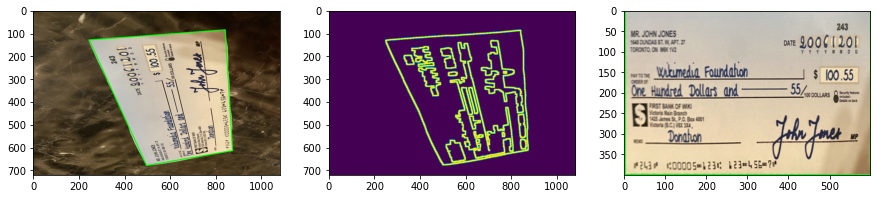

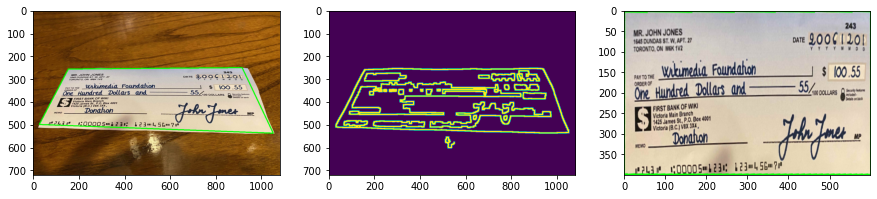

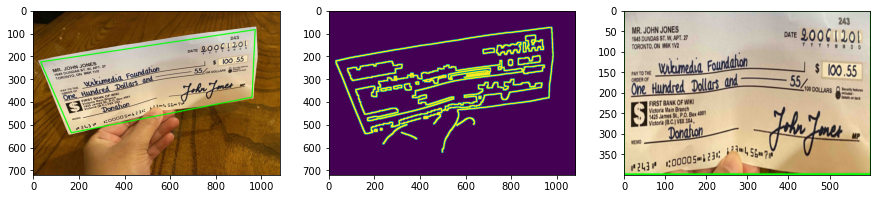

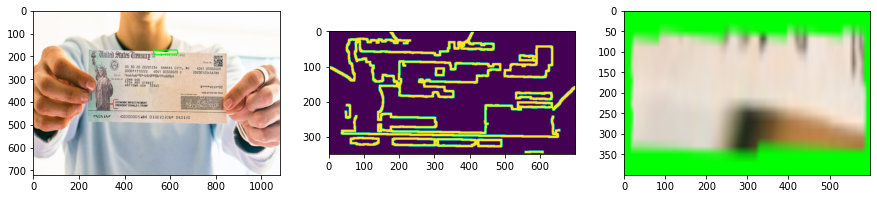

In [46]:
path = "C:\\Users\\Friday\\Desktop\\Spring22\\CS6384\\Projects\\Project3\\samples"
runon_folder(path)